In [2]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#nltk.download()

[nltk_data] Downloading package punkt to /home/rahulmr96/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
georgia = pd.read_csv("georgia_files_merged.csv", index_col=0)
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

In [4]:
# word count
website = re.compile("(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+")  ###Removes URLS
word_freq={}
for i in georgia.iloc[:,3]:
    i=str(i)
    urls = set(re.findall(website, i)) 
    for url in urls:
        i = i.replace(url, "")
    i=i.lower()
    i=word_tokenize(str(i))
    for word in i:
        if word not in word_freq:
            word_freq[word]=1
        else:
            word_freq[word]+=1

text_freq_df=pd.DataFrame({"word": [i for i in word_freq.keys()], "frequency": [i for i in word_freq.values()]})
text_freq_df=text_freq_df.sort_values(by='frequency',ascending=False)
top100=text_freq_df.reset_index().drop('index',axis=1).head(100)
top100.index+=1

In [5]:
from string import punctuation

add_punc = ["’", "``", "'s", "''", "”", "—", "“", "amp", "nan", ",", ".", ":", "?", "—", "@", "&", ";", "!", "$", "#", "-", "%"]

fixed_text_freq_df = text_freq_df.copy()

for word in fixed_text_freq_df['word']:
    if word in punctuation or word in add_punc or word in stop_words:
        #print(word)
        fixed_text_freq_df = fixed_text_freq_df.drop(fixed_text_freq_df[fixed_text_freq_df.word==word].index)




"""cand_dict = {"walker":"herschel-walker", "herschel":"herschel-walker", "herschelwalker":"herschel-walker","walker":"herschel-walker",
             "hershel":"herschel-walker","hershell":"herschel-walker",
             "warnock":"raphael-warnock", "raphael":"raphael-warnock", "reverendwarnock":"raphael-warnock","reverend":"raphael-warnock",
             "warnok":"raphael-warnock","warnnock":"raphael-warnock"}
"""
#print(fixed_text_freq_df[fixed_text_freq_df.word=="abortion"])

pd.set_option('display.max_rows', None)
fixed_text_freq_df.head(10)

,word,frequency
0,rt,10182
1325,senate,10000
1338,walker,7988
31,georgia,7188
1678,herschel,5878
7,ga,3922
280,black,2874
1372,warnock,2616
1584,abortion,2334
30,vote,2124


In [6]:
#replacing democratic candidate words with warnock and republican candidate words with walker
warnock_words = {"rev.", "reverend", "raphael", "dems", "democrat", "democrats", "blue","raphael-warnock", "raphael", "reverendwarnock","reverend",
                 "warnok","warnnock"}
walker_words = {"herschel", "republican", "republicans", "red","walker", "herschel", "herschelwalker","walker",
                "hershel","hershell","herschel-walker"}



def build_dictionary():
    dict = {}
    for word in warnock_words:
        dict[word] = "warnock"
    for word in walker_words:
        dict[word] = "walker"
    return dict


def replace_words(hashmap, tweet):
    word_array = tweet.lower().split(" ")
    for i, word in enumerate(word_array):
        if word in hashmap:
            #print("Replacing {} with {}".format(word, hashmap[word]))
            word_array[i] = hashmap[word]
    return " ".join(word_array)


def fix_df(df):
    print(df.shape)
    df["walker_present"] = False
    df["warnock_present"] = False
    hashmap = build_dictionary()
    for i in range(df.shape[0]):
        row = df.iloc[i, :]
        if type(row["fixedText"]) == str:
            df.iloc[i, 3] = replace_words(hashmap, row["fixedText"])
            if "walker" in df.iloc[i, 3]:
                df.iloc[i, 4] = True
            if "warnock" in df.iloc[i, 3]:
                df.iloc[i, 5] = True
    return df

#georgiaReplaced=georgia.copy()
georgiaReplaced=fix_df(georgia)

(12732, 4)


In [7]:
def clean_text(string):
    re_dict={'rising costs':'inflation','high gas prices':'inflation','gun control':'guns','my body my choice':'abortion',
    'rev.':'warnock', 'reverend':'warnock', 'raphael':'warnock','raphael-warnock':'warnock', 'raphael':'warnock', 'reverendwarnock':'warnock','reverend':'warnock',
                 'warnok':'warnock','warnnock':'warnock',"(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+":'','rt ':' ',
                 'herschel':'walker', 'herschelwalker':'walker','walker':'walker',
                'hershel':'walker','hershell':'walker','herschel-walker':'walker','taxes':'tax','â€™':'',
                'republican senate nominee':'walker','democratic senate nominee':'warnock'}
    
    #print(string, type(string))
    msg=str.lower(str(string))
    for key,val in re_dict.items():
        msg=re.sub(key,val,msg)

    return msg

In [8]:
georgiaReplaced.fixedText=georgiaReplaced.fixedText.map(lambda x: clean_text(x))

In [9]:
def calc_lift(candidate, issue):
    #print('this is issue: ',issue)
    a_b=0
    n_a=0
    n_b=0
    if(candidate==issue):
        return np.nan
    for i in georgiaReplaced.fixedText:
        #print("this is i",str(i))
        words=word_tokenize(str(i))
        a=set(words).intersection(set({candidate, issue}))
        if(len(a)==2):
            a_b+=1
            n_a+=1
            n_b+=1
        elif(len(a)==1):
            if(a.pop()==candidate):
                n_a+=1
            else:
                n_b+=1
    if(n_a==0 or n_b==0):
        return np.nan
    else:
        return a_b/(n_a*n_b)*len(georgiaReplaced)


liftValues = pd.DataFrame(columns=["issue","warnock","walker"])

chosenIssues = ["abortion","gun","community","tax","crime","inflation"]
liftValues.issue = chosenIssues

liftValues.warnock=liftValues.apply(lambda x: calc_lift("warnock",str(x.issue)),axis=1)
liftValues.walker=liftValues.apply(lambda x: calc_lift("walker",str(x.issue)),axis=1)

In [10]:
liftValues

,issue,warnock,walker
0,abortion,0.154038,1.543104
1,gun,1.180101,0.765534
2,community,0.047775,1.918248
3,tax,0.683634,0.646951
4,crime,2.908552,0.211729
5,inflation,3.701628,0.378703


In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download("all")
scores=[]
scores2=[]

new_words = {
    "party":0,
    "abortion":0,
    "gun":0,
    "community":0,
    "tax":0,
    "crime":0,
    "inflation":0
}

analyzer=SentimentIntensityAnalyzer()

analyzer.lexicon.update(new_words)

def sentiment(issue, candidate, window=5):
    for i in georgiaReplaced.fixedText:
        words=word_tokenize(str(i))
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        words = [word for word in words if word not in add_punc]
        if(len(set(words).intersection(set({issue,candidate})))==2):
            #print(words.index('honest'),len(words))
            a = ' '.join(e for e in words[words.index(issue)-window:words.index(issue)+window])
            if a != "":
                #print(a)
                sentiment_score = analyzer.polarity_scores(a)['compound']
                scores.append(sentiment_score)
    #print(scores)
    return np.mean(scores)

In [12]:
sentimentsc = pd.DataFrame(columns=["issue","sentiment_warnock","sentiment_walker"])

chosenIssues = ["abortion","gun","community","tax","crime","inflation"]
sentimentsc.issue = chosenIssues

sentimentsc.sentiment_warnock=sentimentsc.apply(lambda x: sentiment(str(x.issue),"warnock"),axis=1)
sentimentsc.sentiment_walker=sentimentsc.apply(lambda x: sentiment(str(x.issue),"walker"),axis=1)

We've to update the sentiments for only issues for candidates that have high lift

In [13]:
sentimentsc.iloc[0,1]=np.nan
sentimentsc.iloc[1,1]=np.nan
sentimentsc.iloc[2,1]=np.nan
sentimentsc.iloc[3,2]=np.nan
sentimentsc.iloc[4,2]=np.nan
sentimentsc.iloc[5,2]=np.nan
lift_sentiment_df=pd.merge(liftValues,sentimentsc,left_on='issue',right_on='issue')
lift_sentiment_df.replace(np.nan,'-')

,issue,warnock,walker,sentiment_warnock,sentiment_walker
0,abortion,0.154038,1.543104,-,-0.143437
1,gun,1.180101,0.765534,-,-0.149465
2,community,0.047775,1.918248,-,-0.003697
3,tax,0.683634,0.646951,-0.153286,-
4,crime,2.908552,0.211729,-0.204034,-
5,inflation,3.701628,0.378703,-0.258758,-


#### INITIAL FINDINGS FROM LIFT AND SENTIMENT ANALYSIS:
- Although there are several lift values that suggest significance, “abortion” and “guns” are the only issues that have significant higher sentiment values for the candidates
    - This allows us to assume that abortion and guns are the issues that the candidates should focus on since public opinion is not strong one way or the other for the remaining issues
- Although both candidates have significant lift values and negative sentiments for “guns”, advice for the candidates will differ by circumstance
    - Warnock’s negative sentiment is most likely due to his anti-gun stances; however, Walker’s negative sentiment is most likely due to the stories about him holding a gun to his wife’s head. We can give relevant advice based on this context
- Warnock has a significantly low sentiment value with “community” but an extremely low lift value suggests that there is a small minority of people speaking negatively about Warnock and “community”
    - This is most likely not something that Warnock should be concerned about, but it is worth pointing out as a potential issue in the future (people seem to be upset about his relationship with the LGBT community)

In [14]:
top5=['walker','warnock','abortion','gun','community','tax','crime','inflation']

cand_lift=[]
for i in range(0,len(top5)):
    issue1=top5[i]
    lst=[]
    for j in range(0,len(top5)):
        if(j<i):
            lst.append(np.nan)
        else:
            issue2=top5[j]
            lst.append(calc_lift(issue1,issue2))
    cand_lift.append(lst)
cand_lift=pd.DataFrame(cand_lift)
cand_lift.index=top5
cand_lift.columns=top5

We've to then find the dissimilarity matrix to get the MDS plot 

In [15]:
cand_lift_2=(cand_lift.replace(np.nan,0)+cand_lift.T.replace(np.nan,0))
cand_lift_2.replace(0,0.1,inplace=True)
cand_lift_2.loc['inflation','crime']=5
cand_lift_2.loc['crime','inflation']=5
cand_lift_2.loc['inflation','tax']=5
cand_lift_2.loc['tax','inflation']=5
cand_lift_2.loc['community','gun']=0.1
cand_lift_2.loc['gun','community']=0.1
cand_lift_2.loc['warnock','community']=0.1
cand_lift_2.loc['community','warnock']=0.1
cand_dis = cand_lift_2.apply(lambda x: 1/x)
cand_dis.replace([np.inf, -np.inf], 0, inplace=True)

In [16]:
# code modified from GitHub user zack-tan's music lyric analysis project
# creates a metric mds plot with annotations 
def mdsplot_generator(brand_lift_df):
    from sklearn.manifold import MDS
    mds = MDS(n_components=2,dissimilarity='precomputed')
    brand_df_transformed = mds.fit_transform(brand_lift_df)
    brand_df_transformed.shape

    mds_df = pd.DataFrame(brand_df_transformed)
    mds_df['brand'] = list(brand_lift_df.columns)
    mds_df.columns = ['component0', 'component1', 'brand']

    import matplotlib.pyplot as plt
    from scipy.spatial import ConvexHull
    import numpy as np

    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(1, figsize=(8,8))

        # plot data
        x = mds_df.component0
        y = mds_df.component1

        plt.scatter(x, y, s=100)
        
        n = mds_df.brand
        for i, txt in enumerate(n):
            ax.annotate(txt, (x[i], y[i]))
    plt.show()

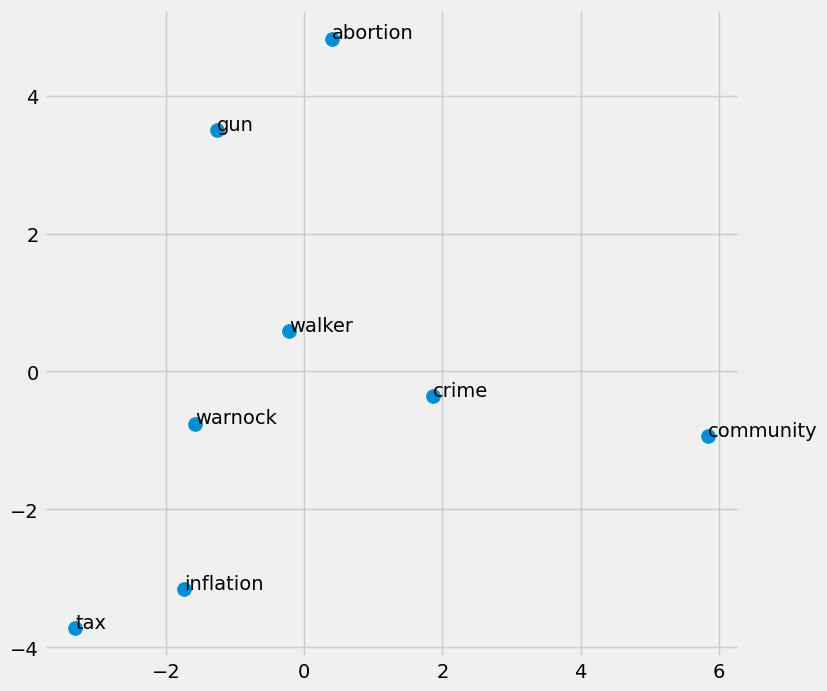

In [17]:
mdsplot_generator(cand_dis)

- Evaluating the lift values MDS Plot, we see that Walker is more closely associated with abortion and Warnock is more closely associated with guns.
    - In the case of Walker, this is most likely because of the recent news that he paid for the abortion of a partner. Given this context and the negative sentiment surrounding the issue, we recommend Walker to avoid emphasizing the typically important GOP talking point to distance himself from the issue. 
    - In the case of Warnock, we recommend that he further associate himself with the issue of gun violence, especially in relation to the allocations of gun-related domestic violence levied against his opponent. However, because of the low sentiment value, we suggest he frame his position around the reduction of violence as it relates to guns, 
    careful to not project the impression that he would erode the rights of responsible gun owners.
- As the MDS plot demonstrates, Warnock is disassociated with community more so than any other issue. If our assumption about the relation to the LGBT Community is correct, this poses an opportunity for Warnock to more closely associate himself with the community and attempt to stimulate positive conversation.
    - This suggestion is already underway, evident in his recent attendance of the Atlanta Pride Parade
    - This is a good opportunity because the low lift value hints that Warnock will not suffer in the minds of many of he chooses not to act, but the opportunity to generate positive association is available to him if needed.


- A word on MDS plot:
    - Because the plot is mapping both relationships of candidates to issues and issues to issues, there are some items on the plot that cannot be perfectly representative of the data used to create it.
    - An example of this can be see with ‘Crime’ as it relates to Warnock and Walker. As the lift values show, ‘Crime’ should be more associated with Warnock, however it appears closer to Walker on the graph. This is due to the disassociation that needs to be represented in relation to the other issues on the graph.
- As with any MDS, we are attempting to reduce multiple relationships into two dimensions, meaning information will be lost. Because of this, we recommend that this MDS should be used as a starting point, but specific investigation of candidates and issues should be graphically represented by reducing the amount of issues represented, and therefore the potential noise that can influence interpretation.

In [18]:
big_cities_ga = ['Atlanta','Columbus, GA','Columbus, Georgia','Augusta','Savannah','Athens','ATL',
                'Decatur','Suwanee']
small_cities_ga = ['Ackworth','Albany, GA','Albany, Georgia''Alpharetta','Austell',
                  'Barnesville','Barrow County','Blairsville','Buford','Carrollton','Centerville',
                  'Cumming','Dahlonega','Dalton','Dawsonville','Duluth','Gainesville','Harlem',
                  'Hephzibah','Hinesville','Jackson','Jasper','Kingsland','Lawrenceville','Lilburn',
                  'Lula','Macon','Madison, GA','Madison, Georgia','Marietta','Newnan','Peachtree Corners','Powder Springs',
                  'Reidsville','Ringgold','Roswell','Smryna','Snellville','Statesboro','Stone Mountain',
                  'Stonecrest','Stockbridge','Summerville','Temple','Thomasville','Tifton','Turin',
                  'Valdosta','Warner Robins','Winder','Woodbine','Woodstock','Sandy Springs','Johns Creek']
master_list_ga = ['GA','Georgia']

In [19]:
georgia_only_df =georgiaReplaced.copy()

georgia_only_df = georgiaReplaced.dropna(subset='location')
georgia_only_df.loc[georgia_only_df['location']
                    .str.contains(r'\b(?:{})\b'.format('|'.join(big_cities_ga))), 'location'] = 'big_city'
georgia_only_df.loc[georgia_only_df['location']
                    .str.contains(r'\b(?:{})\b'.format('|'.join(small_cities_ga))), 'location'] = 'small_city'
georgia_only_df.loc[georgia_only_df['location']
                    .str.contains(r'\b(?:{})\b'.format('|'.join(master_list_ga))), 'location'] = 'other_ga'
georgia_only_df.loc[georgia_only_df['location']
                    .apply(lambda x: x not in ['big_city','small_city','other_ga']), 'location']  = 'non_ga'

In [20]:
georgia_only_df['concatenated_loc_text'] = georgia_only_df['location'] + " " + georgia_only_df['fixedText']

/tmp/ipykernel_28054/3958885582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  georgia_only_df['concatenated_loc_text'] = georgia_only_df['location'] + " " + georgia_only_df['fixedText']


In [25]:
georgia_only_df=georgia_only_df[georgia_only_df['location'].isin(["big_city","small_city"])]

In [26]:
def calc_lift_city(candidate, location):
    a_b=0
    n_a=0
    n_b=0
    if(candidate==location):
        return np.nan
    for i in georgia_only_df.concatenated_loc_text:
        words=word_tokenize(str(i))
        a=set(words).intersection(set({candidate, location}))
        if(len(a)==2):
            a_b+=1
            n_a+=1
            n_b+=1
        elif(len(a)==1):
            if(a.pop()==candidate):
                n_a+=1
            else:
                n_b+=1
    if(n_a==0 or n_b==1):
        return np.nan
    else:
        return a_b/(n_a*n_b)*len(georgia_only_df)

liftValues_loc = pd.DataFrame(columns=["location","warnock","walker"])

chosen_location = ["big_city","small_city"]
liftValues_loc.location = chosen_location

liftValues_loc.warnock=liftValues_loc.apply(lambda x: calc_lift_city("warnock",str(x.location)),axis=1)
liftValues_loc.walker=liftValues_loc.apply(lambda x: calc_lift_city("walker",str(x.location)),axis=1)

In [27]:
liftValues_loc

,location,warnock,walker
0,big_city,0.927643,1.004884
1,small_city,1.209130,0.985884


In [38]:
def sentiment_city(location:str, candidate:str, window=256):
    for i in georgia_only_df.concatenated_loc_text:
        words=word_tokenize(str(i))
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        words = [word for word in words if word not in add_punc]
        if(len(set(words).intersection(set({location,candidate})))==2):
            a = ' '.join(e for e in words)
            if a != "":
                sentiment_score = analyzer.polarity_scores(a)['compound']
                scores.append(sentiment_score)
    return np.mean(scores)


sentiment_all = pd.DataFrame(columns=["location","warnock","walker"])
chosen_location = ["big_city","small_city"]
sentiment_all.location = chosen_location

sentiment_all.warnock=sentiment_all.apply(lambda x: sentiment_city(str(x.location),"warnock"),axis=1)
sentiment_all.walker=sentiment_all.apply(lambda x: sentiment_city(str(x.location),"walker"),axis=1)
sentiment_all.columns=['location','sentiment_warnock','sentiment_walker']

In [39]:
georgia_sent=pd.merge(liftValues_loc,sentiment_all,left_on='location',right_on='location')

In [40]:
georgia_sent

,location,warnock,walker,sentiment_warnock,sentiment_walker
0,big_city,0.927643,1.004884,0.032088,0.034346
1,small_city,1.209130,0.985884,0.030715,0.032662
